<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Modules" data-toc-modified-id="Import-Modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Modules</a></span><ul class="toc-item"><li><span><a href="#General-Modules" data-toc-modified-id="General-Modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General Modules</a></span></li><li><span><a href="#Tensorflow" data-toc-modified-id="Tensorflow-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Tensorflow</a></span></li></ul></li><li><span><a href="#Model-Class" data-toc-modified-id="Model-Class-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Class</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Key-Layer-Names-of-Pretrained-Models" data-toc-modified-id="Key-Layer-Names-of-Pretrained-Models-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Key Layer Names of Pretrained Models</a></span></li></ul></li><li><span><a href="#Model-Units" data-toc-modified-id="Model-Units-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model Units</a></span></li><li><span><a href="#UNET" data-toc-modified-id="UNET-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>UNET</a></span></li><li><span><a href="#UNET+++" data-toc-modified-id="UNET+++-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>UNET+++</a></span></li></ul></li><li><span><a href="#Initialize" data-toc-modified-id="Initialize-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initialize</a></span><ul class="toc-item"><li><span><a href="#Environment-Setup" data-toc-modified-id="Environment-Setup-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Environment Setup</a></span></li><li><span><a href="#Load-Parameters" data-toc-modified-id="Load-Parameters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Load Parameters</a></span></li></ul></li><li><span><a href="#Calculation-Functions" data-toc-modified-id="Calculation-Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculation Functions</a></span><ul class="toc-item"><li><span><a href="#Model-Setup" data-toc-modified-id="Model-Setup-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model Setup</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Loading-Test-Data" data-toc-modified-id="Loading-Test-Data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Loading Test Data</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Test</a></span></li></ul></li><li><span><a href="#Load-And-Compute" data-toc-modified-id="Load-And-Compute-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load And Compute</a></span><ul class="toc-item"><li><span><a href="#Loop-Over-Folds" data-toc-modified-id="Loop-Over-Folds-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Loop Over Folds</a></span></li></ul></li></ul></div>

## Import Modules

### General Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
import platform
import datetime
import pandas as pd
import pickle
import shutil
import importlib
import os

### Tensorflow

In [2]:
import tensorflow as tf
from keras.utils import io_utils, tf_utils
from tensorflow.keras import (layers, models,
                              utils, optimizers,
                              callbacks, regularizers,
                              losses, activations,
                              applications)
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision

## Model Class

#### Key Layer Names of Pretrained Models

In [3]:
imported_layers = {
    'EfficientNetB0': ['block2a_expand_activation',
                       'block3a_expand_activation',
                       'block4a_expand_activation',
                       'block6a_expand_activation',
                       'top_activation'],
    'MobileNetV2': ['block_1_expand_relu',
                    'block_3_expand_relu',
                    'block_6_expand_relu',
                    'block_13_expand_relu',
                    'out_relu'],
    'EfficientNetV2B2': ['block1b_add',
                         'block2c_add',
                         'block4a_expand_activation',
                         'block6a_expand_activation',
                         'top_activation'],
    'EfficientNetV2S': ['block1b_add',
                         'block2d_add',
                         'block3d_add',
                         'block5i_add',
                         'top_activation'],
    'ResNet101V2': ['conv1_conv',
                    'conv2_block2_out',
                    'conv3_block3_out',
                    'conv4_block22_out',
                    'post_relu'],
    'ResNet50V2': ['conv1_conv',
                   'conv2_block3_1_relu',
                   'conv3_block4_1_relu',
                   'conv4_block6_1_relu',
                   'post_relu'],
    'DenseNet201': ['conv1/relu',
                    'pool2_conv',
                    'pool3_conv',
                    'pool4_conv',
                    'relu'],
    'VGG16': ['block2_conv2',
              'block3_conv3',
              'block4_conv3',
              'block5_conv3',
              'block5_pool']
}

### Model Units

In [4]:
class UNET_units():
    def __init__(self, 
                 layer_normalization=True,
                 batch_normalization=True):
        self.layer_normalization=layer_normalization
        self.batch_normalization=batch_normalization

    def normalization(self, l):
        if self.batch_normalization:
            l = layers.BatchNormalization()(l)
        if self.layer_normalization:
            l = layers.LayerNormalization()(l)        
        return l
    
    def AverageAndReshapeLayer(self, input_layer, axis=3):
        input_layer = tf.reduce_mean(input_layer, axis=axis)
        l = input_layer
        return l

    def MaxAndReshapeLayer(self, input_layer, axis=3):
        input_layer = tf.reduce_max(input_layer, axis=axis)
        l = input_layer
        return l
    
    def repeat_element(self, input_layer, rep):
        l = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=-1),
                            arguments = {'repnum':rep})(input_layer)
        return l

    def LSTM_block(self, input_layer, dropout_factor, L2_factor, axis=3, t_now=4):
        l = tf.transpose(input_layer, perm=[0, 3, 1, 2, 4])

        l_now = self.ExpandDimension(l[:, t_now, :, :, :], axis=1)

        l_forward = layers.ConvLSTM2D(l.get_shape()[-1], kernel_size=[3, 3], padding='same',
                                      kernel_regularizer=regularizers.L2(
                                          L2_factor),
                                      dropout=dropout_factor, recurrent_dropout=dropout_factor)(l[:, 0:t_now, :, :, :])
        l_forward = self.ExpandDimension(l_forward, axis=1)

        l_backward = layers.ConvLSTM2D(l.get_shape()[-1], kernel_size=[3, 3], padding='same',
                                       kernel_regularizer=regularizers.L2(
                                           L2_factor),
                                       dropout=dropout_factor, recurrent_dropout=dropout_factor)(l[:, l.shape[1]-1:t_now:-1, :, :, :])
        l_backward = self.ExpandDimension(l_backward, axis=1)

        l = layers.concatenate([l_now, l_forward, l_backward], axis=1)
        l = tf.transpose(l, perm=[0, 2, 3, 4, 1])

        l = layers.Conv3D(
            1, [1, 1, 1], kernel_regularizer=regularizers.L2(L2_factor))(l)
        l = tf.reduce_max(l, axis=4)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        l = layers.Dropout(dropout_factor)(l)
        # l = layers.Activation(activations.relu)(l)
        return l

    def Transformer_block(self, input_layer, dropout_factor, L2_factor):
        def Feed_Forward_cell(l):
            l = tf.transpose(l, perm=[0, 3, 1, 2, 4])
            l = layers.Conv2D(l.shape[-1], [3, 3], input_shape=l.shape[2:], padding='same',
                              kernel_regularizer=regularizers.L2(L2_factor),
                              dropout=dropout_factor)(l)
            l = activations.relu(l)
            l = layers.Conv2D(l.shape[-1], [3, 3], input_shape=l.shape[2:], padding='same',
                              kernel_regularizer=regularizers.L2(L2_factor),
                              dropout=dropout_factor)(l)
            l = tf.transpose(l, perm=[0, 2, 3, 1, 4])
            return l

        def AddAndNorm(l, c):
            l = l + c
            l = layers.LayerNormalization()(l)
            return l

        c1 = input_layer
        l = layers.MultiHeadAttention(
            num_heads=2, key_dim=2, attention_axes=(3,))(input_layer, input_layer)
        l = AddAndNorm(l, c1)
        c2 = l
        l = Feed_Forward_cell(l)
        l = AddAndNorm(l, c2)
        l = layers.AveragePooling3D((1, 1, l.shape[3]))(l)
        l = tf.squeeze(l)
        return l

    def ExpandDimension(self, input_layer, axis=3):
        shape = (-1,)
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        for i in range(1, input_dim):
            if not i == axis:
                shape += (input_shape[i],)
            else:
                shape += (1,)
                shape += (input_shape[i],)
        l = tf.reshape(input_layer, shape=shape)
        return l

    def AttentionGate(self, input_layer, query_layer, dropout_factor, L2_factor, F_int=128):
        if len(input_layer.shape) == 5:
            stride_factor_xy = int(input_layer.shape[1]/query_layer.shape[1])
            stride_factor_z = int(input_layer.shape[3]/query_layer.shape[3])
            Conv = layers.Conv3D
            kernel_size = [1, 1, 1]
            strides = [stride_factor_xy, stride_factor_xy, stride_factor_z]
            Up = layers.UpSampling3D(size=strides)
        elif len(input_layer.shape) == 4:
            stride_factor_xy = int(input_layer.shape[1]/query_layer.shape[1])
            Conv = layers.Conv2D
            kernel_size = [1, 1]
            strides = [stride_factor_xy, stride_factor_xy]
            Up = layers.UpSampling2D(size=strides)

        x1 = Conv(F_int, kernel_size=kernel_size, strides=strides,
                  kernel_regularizer=regularizers.l2(L2_factor))(input_layer)
        q1 = Conv(F_int, kernel_size=kernel_size,
                  kernel_regularizer=regularizers.l2(L2_factor))(query_layer)

        x1 = layers.Add()([x1, q1])
        x1 = self.normalization(x1)
        x1 = layers.Activation(activations.relu)(x1)
        x1 = layers.Dropout(dropout_factor)(x1)

        x1 = Conv(1, kernel_size=kernel_size,
                  kernel_regularizer=regularizers.l2(L2_factor))(x1)
        x1 = self.normalization(x1)
        x1 = layers.Activation(activations.sigmoid)(x1)
        x1 = layers.Dropout(dropout_factor)(x1)

        x1 = Up(x1)
        x1 = self.repeat_element(x1, input_layer.shape[-1])
        output = layers.Multiply()([x1, input_layer])
        output = self.normalization(output)
        return output

    def Depth_conv_cell(self, input_layer, dropout_factor, L2_factor,
                        depth_kernel_size=3, filters=32, padding='same'):
        l = layers.Conv3D(kernel_size=[1, 1, depth_kernel_size], filters=filters,
                          kernel_regularizer=regularizers.l2(L2_factor),
                          padding=padding)(input_layer)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        l = layers.Dropout(dropout_factor)(l)
        return l

    def Channel_FC_cell(self, input_layer, dropout_factor, L2_factor):
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        if input_dim == 4:
            l = layers.Conv2D(kernel_size=[1, 1], filters=input_shape[-1],
                              kernel_regularizer=regularizers.l2(L2_factor),
                              padding='same')(input_layer)
        elif input_dim == 5:
            l = layers.Conv3D(kernel_size=[1, 1, 1], filters=input_shape[-1],
                              kernel_regularizer=regularizers.l2(L2_factor),
                              padding='same')(input_layer)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        l = layers.Dropout(dropout_factor)(l)
        return l

    def Conv2D_Cell(self, input_layer, filters, dropout_factor, L2_factor,
                    dropout=True, kernel_size=[3, 3]):
        l = layers.Conv2D(filters=filters,
                          kernel_size=kernel_size,
                          kernel_regularizer=regularizers.l2(L2_factor),
                          padding='same')(input_layer)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        if dropout:
            l = layers.Dropout(dropout_factor)(l)
        return l

    def Conv3D_Cell(self, input_layer, filters, dropout_factor, L2_factor,
                    dropout=True, kernel_size=[3, 3, 1]):
        l = layers.Conv3D(filters=filters,
                          kernel_size=kernel_size,
                          kernel_regularizer=regularizers.l2(L2_factor),
                          padding='same')(input_layer)
        l = self.normalization(l)
        l = layers.Activation(activations.relu)(l)
        if dropout:
            l = layers.Dropout(dropout_factor)(l)
        return l

    def Conv_Cell(self, input_layer, filters, dropout_factor, L2_factor, kernal_size=3):
        if len(input_layer.get_shape()) == 5:
            l = self.Conv3D_Cell(input_layer, filters,
                                 dropout_factor, L2_factor,
                                 kernel_size=[kernal_size, kernal_size, 1])
        elif len(input_layer.get_shape()) == 4:
            l = self.Conv2D_Cell(input_layer, filters,
                                 dropout_factor, L2_factor,
                                 kernel_size=[kernal_size, kernal_size])
        return l

    def Res_Block(self, input_layer, filters, dropout_factor, L2_factor):
        l = self.Conv_Cell(input_layer, filters, dropout_factor, L2_factor)
        l = self.Conv_Cell(l, input_layer.shape[-1], dropout_factor, L2_factor)
        l = layers.Add()([input_layer, l])
        l = self.Conv_Cell(l, filters, dropout_factor, L2_factor)
        return l

    def Conv_Block(self, input_layer, this_filters, sub_layers,
                       dropout_factor, L2_factor,
                       res=True):
        if res:
            this_C_Cell = self.Res_Block
        else:
            this_C_Cell = self.Conv_Cell

        l = input_layer
        for i in range(sub_layers):
            l = this_C_Cell(l, this_filters, dropout_factor, L2_factor)
        return l
            
    def DownWard_Cell(self, l):
        if len(l.get_shape()) == 5:
            l = layers.MaxPool3D(pool_size=(2, 2, 1))(l)
        elif len(l.get_shape()) == 4:
            l = layers.MaxPool2D()(l)
        return l

    def UpWard_Cell(self, l, up_sample='up_sample'):
        if up_sample == 'up_sample':
            if len(l.get_shape()) == 5:
                l = layers.UpSampling3D(size=(2, 2, 1))(l)
            elif len(l.get_shape()) == 4:
                l = layers.UpSampling2D()(l)
        elif up_sample == 'conv2dtranspose':
            this_filters = l.shape[-1]
            if len(l.get_shape()) == 5:
                l = layers.Conv3DTranspose(filters=this_filters,
                                           kernel_size=[3, 3, 3],
                                           strides=(2, 2, 1),
                                           padding='same')(l)
            elif len(l.get_shape()) == 4:
                l = layers.Conv2DTranspose(filters=this_filters,
                                           kernel_size=[3, 3],
                                           strides=(2, 2),
                                           padding='same')(l)
            l = self.normalization(l)
            l = layers.Activation(activations.relu)(l)

        return l

### UNET

In [5]:
class UNET(UNET_units):
    def __init__(self,
                 num_classes=1,
                 block_num=5,
                 sub_layers=3,
                 res=True,
                 up_sample='up_sample',
                 dropout_factor=0,
                 L2_factor=1e-15,
                 filter_list=[16, 32, 64, 128, 256, 512],
                 encoder='vanilla',
                 transfer=False,
                 transfer_trainable=False,
                 reduce_dim_method='skip',
                 input_stem_seq=[],
                 time_label=[-4, -3, -2, -1, 0, 1, 2, 3],
                 AG=False,
                 layer_normalization=True,
                 batch_normalization=True,
                 conv_before_connection=0,
                 connection_kernal_size=1,
                 inter_medium_conv=True,
                 include_top=True
                ):
        super().__init__(layer_normalization=layer_normalization,
                         batch_normalization=batch_normalization)
        self.encoder_list = ['EfficientNetB0', 
                             'EfficientNetV2B2',
                             'EfficientNetV2S',
                             'ResNet101V2',
                             'ResNet50V2',
                             'DenseNet201',
                             'VGG16']
        self.block_num = block_num
        if type(sub_layers) == int:
            self.sub_layers = [sub_layers] * self.block_num
        else:
            self.sub_layers = sub_layers
        #self.sub_layers = sub_layers
        self.res = res
        self.up_sample = up_sample
        self.dropout_factor = dropout_factor
        self.L2_factor = L2_factor
        self.filter_list = filter_list[0:block_num]
        self.encoder = encoder
        self.transfer_trainable = transfer_trainable
        self.reduce_dim_method = reduce_dim_method
        self.input_stem_seq = input_stem_seq
        self.time_label = time_label
        self.AG = AG
        self.conv_before_connection = conv_before_connection
        self.connection_kernal_size = connection_kernal_size
        self.layer_normalization = layer_normalization
        self.batch_normalization = batch_normalization
        self.inter_medium_conv = inter_medium_conv
        self.include_top = include_top
        
        if not self.encoder in self.encoder_list:
            self.transfer = False
        else:
            self.transfer = transfer

        if num_classes <= 2:
            self.num_classes = 1
        else:
            self.num_classes = num_classes
            
    def input_stem(self, input_layer, process_sequence):
        l = input_layer
        l_dim = len(l.get_shape())
        for seq in process_sequence:
            if seq == 'depth_conv' and l_dim == 5:
                l = self.Depth_conv_cell(l, self.dropout_factor, self.L2_factor)
            elif seq == 'channel_FC':
                l = self.Channel_FC_cell(l, self.dropout_factor, self.L2_factor)
        return l
    
    def ReduceDimLayer(self, input_layer, dropout_factor, L2_factor):
        if self.reduce_dim_method == 'skip':
            l = self.AverageAndReshapeLayer(input_layer)
        elif self.reduce_dim_method == 'LSTM':
            t_now = self.time_label.index(0)
            l = self.LSTM_block(input_layer, dropout_factor, L2_factor, t_now=t_now)
        elif self.reduce_dim_method == 'transformer':
            l = self.Transformer_block(input_layer, dropout_factor, L2_factor)
        return l
    
    def Pretrained_Encoder(self, input_layer):
        if self.transfer:
            weights = 'imagenet'
        else:
            weights = None
        print(weights)
        if self.encoder == 'VGG16':
            this_Encoder = applications.VGG16
            if self.transfer:
                first_id = 0
            else:
                first_id = 0
        if self.encoder == 'EfficientNetB0':
            this_Encoder = applications.EfficientNetB0
            if self.transfer:
                first_name = 'rescaling_1'
            else:
                first_name = 'normalization'
        elif self.encoder == 'EfficientNetV2B2':
            this_Encoder = applications.EfficientNetV2B2
            if self.transfer:
                first_id = 2
            else:
                first_id = 2
        elif self.encoder == 'EfficientNetV2S':
            this_Encoder = applications.EfficientNetV2S
            if self.transfer:
                first_id = 1
            else:
                first_id = 1
        elif self.encoder == 'ResNet101V2':
            this_Encoder = applications.ResNet101V2
            if self.transfer:
                first_id = 0
            else:
                first_id = 0
        elif self.encoder == 'ResNet50V2':
            this_Encoder = applications.ResNet50V2
            if self.transfer:
                first_id = 0
            else:
                first_id = 0
        elif self.encoder == 'DenseNet201':
            this_Encoder = applications.DenseNet201
            if self.transfer:
                first_id = 0
            else:
                first_id = 0
                
        def through_Back_Bone(l, index):
            Back_Bone = this_Encoder(weights=weights,
                include_top=False, input_tensor=l)
            if (not self.transfer_trainable) and self.transfer:
                Back_Bone.trainable = False
            for layer in Back_Bone.layers:
                layer._name = layer.name + f'_{index}'
            outputs = [Back_Bone.get_layer(index=first_id).output, ]
            C_layers_name = imported_layers[self.encoder]
            Cs = [Back_Bone.get_layer(name + f'_{index}').output for name in C_layers_name]
            for i in range(self.block_num):
                outputs.append(Cs[i])
            return outputs
        
        l = input_layer
        if len(l.shape) == 5 and l.shape[3] > 1:
            temp_op = []
            print(input_layer.shape)
            for t in range(l.shape[3]):
                l = input_layer[:,:,:,t,:]
                print(l.shape)
                temp_op.append(through_Back_Bone(l, t))
            
            outputs = []
            for i in range(len(temp_op[0])):
                if len(temp_op[0][i].shape) == 4:
                    this_op_list = []
                    for j in range(len(temp_op)):
                        this_op_list.append(self.ExpandDimension(temp_op[j][i]))
                    this_op = layers.concatenate(this_op_list, axis=3)
                else:
                    this_op = temp_op[0][i]
                print(this_op.shape)
                outputs.append(this_op)
        else:
            if len(l.shape) == 5:
                l = self.ReduceDimLayer(input_layer,
                                        dropout_factor=self.dropout_factor,
                                        L2_factor=self.L2_factor)        
            outputs = through_Back_Bone(l,index=0)    
        return outputs
    
    def Vanilla_Encoder(self, input_layer):
        l = input_layer
        outputs = []
        for i in range(self.block_num):
            l = self.Conv_Block(l,
                                this_filters=self.filter_list[i],
                                sub_layers=self.sub_layers[i],
                                res=self.res,
                                dropout_factor=self.dropout_factor,
                                L2_factor=self.L2_factor
                               )
            outputs.append(l)
            l = self.DownWard_Cell(l)
        outputs.append(l)  
        return outputs
    
    def DownWard_Stream(self, input_layer):
        if self.encoder == 'vanilla':
            ls = self.Vanilla_Encoder(input_layer)
        elif self.encoder in self.encoder_list:
            ls = self.Pretrained_Encoder(input_layer)
        return ls
    
    def UpWard_Stream(self, input_layers):
        l = input_layers[-1]
        for i in range(self.block_num):
            l = self.Conv_Block(l,
                                  this_filters=self.filter_list[-i-1],
                                  sub_layers=self.sub_layers[-i-1],
                                  res=self.res,
                                  dropout_factor=self.dropout_factor,
                                  L2_factor=self.L2_factor
                                 )
            if self.AG:
                q = l
            l = self.UpWard_Cell(l, up_sample=self.up_sample)
            if self.AG:
                l = self.Concatenate(i, input_layers, l, query=q)
            else:
                l = self.Concatenate(i, input_layers, l)        
        l = self.Conv_Block(l,
                            this_filters=int(self.filter_list[0]/2),
                            sub_layers=1,
                            res=self.res,
                            dropout_factor=self.dropout_factor,
                            L2_factor=self.L2_factor
                            )
        l = self.UpWard_Cell(l, up_sample=self.up_sample)
        if self.inter_medium_conv:
            l = self.Conv_Block(l,
                                this_filters=int(np.sqrt(self.filter_list[0]/4*3)),
                                sub_layers=1,
                                res=self.res,
                                dropout_factor=self.dropout_factor,
                                L2_factor=self.L2_factor
                                )
        else:
            l = self.Conv_Block(l,
                                this_filters=int(self.filter_list[0]/4),
                                sub_layers=1,
                                res=self.res,
                                dropout_factor=self.dropout_factor,
                                L2_factor=self.L2_factor
                                )
        l = self.DownWard_Cell(l)
        return l
    
    def Concatenate(self, i, input_layers, l, query=None):
        j = input_layers[-i-2]
        l_shape = l.get_shape()
        l_dim = len(l_shape)
        j_shape = j.get_shape()
        j_dim = len(j_shape)

        for c in range(self.conv_before_connection):
            j = self.Conv_Cell(j,
                               filters=l_shape[-1],
                               dropout_factor=self.dropout_factor,
                               L2_factor=self.L2_factor,
                               kernal_size=self.connection_kernal_size)
        if l_dim > j_dim:
            j = self.ExpandDimension(j)
        elif l_dim < j_dim:
            j = self.ReduceDimLayer(j, self.dropout_factor, self.L2_factor)
        if self.AG:
            j = self.AttentionGate(j, query, self.dropout_factor, self.L2_factor)
        l = layers.concatenate([l, j])
        l = self.normalization(l)
        return l

    def Segmentation_Stem(self, input_layer, activation=True):
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        if input_dim == 5:
            input_layer = self.ReduceDimLayer(input_layer)
        l = layers.Dropout(self.dropout_factor)(input_layer)
        if self.inter_medium_conv:
            l = self.Conv_Cell(l,
                               filters=3,
                               dropout_factor=self.dropout_factor,
                               L2_factor=self.L2_factor,
                               kernal_size=3)
        l = layers.Conv2D(filters=self.num_classes,
                          kernel_size=[1, 1],
                          padding='same',
                          kernel_regularizer=regularizers.L2(self.L2_factor))(l)
        if activation:
            l = layers.Activation(activations.sigmoid)(l)
        return l
    
    def Add_regularizer_into_pretrained_backbone(self, model):
        for layer in model.layers:
            if len(layer.trainable_weights) > 0:
                try:
                    if layer.kernel_regularizer == None:
                        layer.add_loss(lambda: (tf.math.reduce_variance(layer.kernel) +
                                                tf.math.reduce_mean(layer.kernel)**2) * self.L2_factor)
                        print(layer.name)
                except:
                    pass
        return model
    
    def Get_PreTrained_Weights(self, model):
        if self.encoder == 'EfficientNetB0':
            C_layer_names = imported_layers['EfficientNetB0']
            Encoder_for_weight = applications.EfficientNetB0(
                include_top=False, weights='imagenet')
            run = True
            i = 8
            while run:
                model.layers[i].set_weights(
                    Encoder_for_weight.layers[i-3].get_weights())
                if not self.transfer_trainable:
                    model.layers[i].trainable = False
                else:
                    model.layers[i].trainable = True
                if model.layers[i].name == C_layer_names[self.block_num - 1]:
                    run = False
                else:
                    i += 1

        return model
    
    def Output(self, input_layer, activation):        
        l = self.input_stem(input_layer, self.input_stem_seq)
        ls = self.DownWard_Stream(l)
        for i, l in enumerate(ls):
            if len(l.shape) == 5:
                l = self.ReduceDimLayer(l, dropout_factor=self.dropout_factor, L2_factor=self.L2_factor)
            ls[i] = l
        l = self.UpWard_Stream(ls)
        output_layer = self.Segmentation_Stem(l, activation=activation)
        
        return output_layer
    
    def build_model(self, input_shape):
        input_layer = layers.Input(input_shape)
        output_layer = self.Output(input_layer, activation=self.include_top)
        model = models.Model(input_layer, output_layer)

        if self.transfer_trainable:
            model = self.Add_regularizer_into_pretrained_backbone(model)

        return model

### UNET+++

In [6]:
class UNET_3plus(UNET):
    def __init__(self,
                 num_classes=1,
                 block_num=5,
                 sub_layers=3,
                 res=True,
                 up_sample='up_sample',
                 dropout_factor=0,
                 L2_factor=1e-15,
                 filter_list=[16, 32, 64, 128, 256, 512],
                 encoder='vanilla',
                 transfer=False,
                 transfer_trainable=False,
                 reduce_dim_method='skip',
                 input_stem_seq=[],
                 time_label=[-4, -3, -2, -1, 0, 1, 2, 3],
                 AG=False
                ):
        super().__init__(num_classes=num_classes,
                        block_num=block_num,
                        sub_layers=sub_layers,
                        res=res,
                        up_sample=up_sample,
                        dropout_factor=dropout_factor,
                        L2_factor=L2_factor,
                        filter_list=filter_list,
                        encoder=encoder,
                        transfer=transfer,
                        transfer_trainable=transfer_trainable,
                        reduce_dim_method=reduce_dim_method,
                        input_stem_seq=input_stem_seq,
                        time_label=time_label,
                        AG=AG)
        
    def UpWard_Stream(self, input_layers):
        l = input_layers[-1]
        for i in range(self.block_num):
            l = self.Conv_Block(l,
                                  this_filters=self.filter_list[-i-1],
                                  sub_layers=self.sub_layers,
                                  res=self.res,
                                  dropout_factor=self.dropout_factor,
                                  L2_factor=self.L2_factor
                                 )
            if self.AG:
                q = l
            l = self.UpWard_Cell(l, up_sample=self.up_sample)
            input_layers.append(l)
            if self.AG:
                l = self.Concatenate_3(i, input_layers, l, query=q)
            else:
                l = self.Concatenate_3(i, input_layers, l)        
        l = self.Conv_Block(l,
                            this_filters=int(self.filter_list[0]/2),
                            sub_layers=1,
                            res=self.res,
                            dropout_factor=self.dropout_factor,
                            L2_factor=self.L2_factor
                            )
        l = self.UpWard_Cell(l, up_sample=self.up_sample)
        l = self.Conv_Block(l,
                            this_filters=int(self.filter_list[0]/4),
                            sub_layers=1,
                            res=self.res,
                            dropout_factor=self.dropout_factor,
                            L2_factor=self.L2_factor
                            )
        l = self.DownWard_Cell(l)
        return l
    
    def Concatenate_3(self, i, input_layers, l, query=None):
        concate_idx = [*range(self.block_num-i)] + [*range(self.block_num, self.block_num+i)]
        for k in concate_idx:
            j = input_layers[k]
            l_shape = l.get_shape(); l_dim = len(l_shape)
            j_shape = j.get_shape(); j_dim = len(j_shape)
            if l_dim > j_dim:
                j = self.ExpandDimension(j)
            elif l_dim < j_dim:
                j = self.AverageAndReshapeLayer(j)
            MP_ratio = int(j_shape[1] / l_shape[1])
            if MP_ratio > 1:
                if j_dim == 4:
                    j = layers.MaxPool2D((MP_ratio, MP_ratio))(j)
                elif j_dim == 5:
                    j = layers.MaxPool3D((MP_ratio, MP_ratio, MP_ratio))(j)
            elif MP_ratio < 1:
                UP_ratio = int(l_shape[1] / j_shape[1])
                if l_dim == 5:
                    if self.up_sample == 'up_sample':
                        j = layers.UpSampling3D(size=(UP_ratio, UP_ratio, UP_ratio))(j)
                    elif self.up_sample == 'conv2dtranspose':
                        j = layers.Conv3DTranspose(filters=j.shape[-1],
                                                   kernel_size=[3, 3, 3],
                                                   strides=(UP_ratio, UP_ratio, UP_ratio),
                                                   padding='same')(j)
                        j = layers.BatchNormalization()(j)
                        j = layers.LayerNormalization()(j)
                        j = layers.Activation(activations.relu)(j)
                elif l_dim == 4:
                    if self.up_sample == 'up_sample':
                        j = layers.UpSampling2D(size=(UP_ratio, UP_ratio))(j)
                    elif self.up_sample == 'conv2dtranspose':
                        j = layers.Conv2DTranspose(filters=j.shape[-1],
                                                   kernel_size=[3, 3, 3],
                                                   strides=(UP_ratio, UP_ratio),
                                                   padding='same')(j)
                        j = layers.BatchNormalization()(j)
                        j = layers.LayerNormalization()(j)
                        j = layers.Activation(activations.relu)(j)
            
            if self.AG:
                j = self.AttentionGate(j, query, self.dropout_factor, self.L2_factor, F_int=16)

            l = layers.concatenate([l, j])
        l = layers.BatchNormalization()(l)
        j = layers.LayerNormalization()(j)
        return l

## Initialize

### Environment Setup

In [7]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load Parameters

In [8]:
class LoadInitialParameters():
    def str_to_bool(self, string):
        if string == 'True':
            Bool = True
        elif string == 'False':
            Bool = False
        return Bool

    def str_to_list(self, string):
        L = string.split('[')[1].split(']')[0].split(',')
        output_list = []
        for l in L:
            try:
                output_list.append(int(l))
            except:
                output_list.append(float(l))
        return output_list
    
    def str_to_nest_list(self, string):
        string.replace(' ','')
        string = string[1:-1]
        order = 0
        for i in string:
            if i == '[':
                order += 1
            else:
                break
        elements = string.split('],[')
        List = []
        for e in elements:
            this_list = self.str_to_list(e)
            List.append(this_list)
        return List
        

    def str_to_test_choice(self, string):
        Ls = string.split('(')[1].split(')')[0].split(',')
        Ls = [Ls[0] + ',' + Ls[1] + ',' + Ls[2], Ls[3] + ',' + Ls[4] + ',' + Ls[5]]
        L = tuple([self.str_to_list(l) for l in Ls])
        return L
    
    def method_selector(self, string):
        try:
            f = float(string)
            if int(f) == f:
                value = int(f)
            else:
                value = f
        except:
            if string[0] == '[':
                if len(string) > 2:
                    if string[1] == '[':
                        value = self.str_to_nest_list(string)
                    else:
                        value = self.str_to_list(string)
                    
                else:
                    value = []
            elif string[0] == '(':
                value = self.str_to_test_choice(string)
            elif string == 'True' or string == 'False':
                value = self.str_to_bool(string)
            else:
                value = string
        return value
    
    def load_initial_parameters(self, filename):
        with open(filename, 'r') as f:
            Ls = f.readlines()
        initial_parameters = {}
        head_tail = 0
        for L in Ls:
            l = L[0:-1]
            col = l.split(':')[0]
            value_str = l.split(':')[1]
            value = self.method_selector(value_str)
            print([col, value, type(value)])
            initial_parameters[col] = value
            globals()[col] = value
        return initial_parameters

In [9]:

include_top = False
fold_nums = [3, 4, 5, 6, 0, 1, 2, 7, 8, 9]
#fold_nums = [3, 4, 5, 6]
#fold_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

output_path = './Segmented_timestream_data/'
if not os.path.exists(output_path):
    os.mkdir(output_path)
if not include_top:
    output_path += 'No_Activation/'
    if not os.path.exists(output_path):
        os.mkdir(output_path)

In [10]:
main_model_path = '.\\saved_model_data\\Three_2D_models\\'
parameter_filename = main_model_path + 'initial_parameters.txt'
LIP = LoadInitialParameters()
initial_parameters = LIP.load_initial_parameters(parameter_filename)

['batch_size', 8, <class 'int'>]
['epochs', 1000, <class 'int'>]
['first_lr', 0.001, <class 'float'>]
['loss_flag', 'asym_UFL', <class 'str'>]
['weight', 0.5, <class 'float'>]
['delta', 0.6, <class 'float'>]
['gamma', 0.5, <class 'float'>]
['iaa_aug', True, <class 'bool'>]
['aug_method', 'SomeOf', <class 'str'>]
['num_aug', [0, 2], <class 'list'>]
['rotate_rate', 0.4, <class 'float'>]
['rot90_rate', 1, <class 'int'>]
['filp_rate', 1, <class 'int'>]
['random_state', 1450, <class 'int'>]
['subtract_mean', False, <class 'bool'>]
['quick_test', False, <class 'bool'>]
['short_train', False, <class 'bool'>]
['sample_mode', 'large_y', <class 'str'>]
['cut_zero_y_samples', False, <class 'bool'>]
['train_verbose', 2, <class 'int'>]
['print_model_summry', True, <class 'bool'>]
['optuna_sample_mode', 'grid', <class 'str'>]
['grid_log_L2', [-9, -8, -7, -6, -5, -4], <class 'list'>]
['grid_dropout', [0.05], <class 'list'>]
['random_log_L2_range', [-10, -5], <class 'list'>]
['random_dropout_range', [

## Calculation Functions

### Model Setup

In [11]:
backbone_list = ['ResNet101V2', 'DenseNet201', 'VGG16']

In [12]:
if model_architecture == 'UNET':
    this_UNET = UNET
elif model_architecture == 'UNET+++':
    this_UNET = UNET_3plus

In [13]:
model_modules = []
for backbone in backbone_list:
    MM = this_UNET(num_classes=num_classes,
                    block_num=block_num,
                    sub_layers=sub_layers,
                    res=res,
                    up_sample=up_sample,
                    dropout_factor=dropout_factor,
                    L2_factor=L2_factor,
                    filter_list=filter_list,
                    encoder=backbone,
                    transfer=transfer,
                    transfer_trainable=transfer_trainable,
                    reduce_dim_method=reduce_dim_method,
                    input_stem_seq=[],
                    time_label=time_label,
                    AG=AG,
                    conv_before_connection=conv_before_connection,
                    connection_kernal_size=connection_kernal_size,
                    layer_normalization=layer_normalization,
                    batch_normalization=batch_normalization,
                    inter_medium_conv=inter_medium_conv,
                    include_top = include_top
                    )
    model_modules.append(MM)

In [14]:
my_models = []
my_cuts = []
for i, MM in enumerate(model_modules):
    model = MM.build_model((256, 256, 1, 3))
    this_weight_fn = main_model_path + backbone_list[i] + '/model_weights.h5'
    print(this_weight_fn)
    model.load_weights(this_weight_fn)
    my_models.append(model)
    
    this_cut_fn = main_model_path + backbone_list[i] + '/Threshold.txt'
    with open(this_cut_fn, 'r') as f:
        my_cuts.append(float(f.read()))

imagenet
.\saved_model_data\Three_2D_models\ResNet101V2/model_weights.h5
imagenet
.\saved_model_data\Three_2D_models\DenseNet201/model_weights.h5
imagenet
.\saved_model_data\Three_2D_models\VGG16/model_weights.h5


### Functions

In [15]:
def y_binarization(y, threshold):
    new_y = y * 0
    new_y[y >= threshold] = 1
    return new_y

In [24]:
def sigmoid(a, x0, k):
    def func(x):
        return a/(1+np.exp(-k*(x-x0)))
    return func

In [17]:
def seg_2d(x, Models, weights=None, include_top=False, thresholds=None, k=4):
    # Dimension of x: time_step, width, height, 1, channels
    if thresholds is None:
        thresholds = [0.5] * len(Models)
    if weights is None:
        weights = [1] * len(Models)
    weights = np.array(weights) / sum(weights)
    if include_top:
        yp = np.zeros(list(x.shape[0:3])+[1])
        for i in range(len(Models)):
            this_threshold = thresholds[i]
            this_y = Models[i].predict(x, verbose=0)
            this_y = y_binarization(this_y, this_threshold)
            yp += this_y * weights[i]
        return yp
    else:
        yp = np.zeros(list(x.shape[0:3])+[3])
        for i in range(len(Models)):
            this_threshold = thresholds[i]
            # 因為 threshold 是從經過 sigmoid function 活化之後才取的，而這邊模型的值沒有活化
            # 所以這邊必須反推原始值 y0 為多少會讓活化之後的值等於 threshold
            this_y0 = -np.log(1/this_threshold - 1)
            #-----------------------------------------------------------------------
            this_y1 = Models[i].predict(x, verbose=0)
            this_y2 = (this_y1 - np.min(this_y1)) / (np.max(this_y1) - np.min(this_y1))
            #----y0 要做一樣的線性轉換
            this_y0 = (this_y0 - np.min(this_y1)) / (np.max(this_y1) - np.min(this_y1))
            #--------------------------
            this_y3 = sigmoid(1, this_y0, k)(this_y2)
            #this_y4 = (this_y3 - np.min(this_y3)) / (np.max(this_y3) - np.min(this_y3))
            yp[...,i] = np.squeeze(this_y3)
        return yp

In [18]:
def seg_a_sample(X, Models, weights=None, include_top=False, thresholds=None, k=4):
    x = np.transpose(X, axes=[2, 0, 1, 3])
    x = np.expand_dims(x, axis = 3)
    yp = seg_2d(x, Models, weights, include_top, thresholds, k)
    return yp

### Loading Test Data

In [20]:
class Single_Picture_Loader():
    def __init__(self, stride_2d=[1, 1],
                 ash_color_flag=True,
                 channels=[[8, 9, 10], [11, 12, 13], [14, 15, 16]],
                 time_steps_projection=[[0, 0, 0, 0, 1, 0, 0, 0],
                                        [0, -1, -2, -3, 12, -3, -2, -1],
                                        [0, 0, 0, -1, 2, -1, 0, 0]],
                 subtract_mean=False
                 ):
        self.new_size = [int(256/s) for s in stride_2d]
        self.stride_2d = stride_2d
        self.ash_color_flag = ash_color_flag
        self.channels = channels
        self.subtract_mean = subtract_mean
        self.time_steps_projection = time_steps_projection
        if self.ash_color_flag:
            self.num_channels = 3
        else:
            self.num_channels = len(channels)
        self.num_time_steps = len(time_steps_projection)
        self.shape = self.new_size + [self.num_channels, self.num_time_steps]

    def resize_2D(self, X):
        new_X = np.zeros([self.new_size[0], self.new_size[1], X.shape[2]])
        for i in range(self.new_size[0]):
            for j in range(self.new_size[1]):
                new_X += X[i::self.new_size[0], j::self.new_size[1], :]
        new_X /= np.prod(self.new_size)
        return new_X

    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    def normalize_unity(self, data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    def ash_color_scheme(self, path):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)

        if self.subtract_mean:
            for i in [8, 9, 10, 12, 13, 16]:
                this_band = np.load(path + f'band_{i:02d}.npy')
                for t in range(this_band.shape[-1]):
                    this_band[..., t] = self.normalize_unity(this_band[..., t])
                if i == 8:
                    M = this_band / 6
                else:
                    M += this_band / 6

        band15 = np.load(path + f'band_15.npy')
        band14 = np.load(path + f'band_14.npy')
        band11 = np.load(path + f'band_11.npy')
        if self.subtract_mean:
            r = self.normalize_unity(self.normalize_range(
                band15 - band14, _TDIFF_BOUNDS) - M)
            g = self.normalize_unity(self.normalize_range(
                band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS) - M)
            b = self.normalize_unity(
                self.normalize_range(band14, _T11_BOUNDS) - M)
        else:
            r = self.normalize_range(band15 - band14, _TDIFF_BOUNDS)
            g = self.normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
            b = self.normalize_range(band14, _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        return false_color

    def time_step_process(self, data):
        output = []
        for this_t in self.time_steps_projection:
            for i, j in enumerate(this_t):
                if i == 0:
                    this_d = data[:, :, :, i] * j
                else:
                    this_d += data[:, :, :, i] * j
            this_d = np.squeeze(self.normalize_range(
                this_d, [np.min(this_d), np.max(this_d)]))
            output.append(this_d)
        output = np.transpose(np.array(output), axes=[1, 2, 0, 3])
        return output

    def channel_combination(self, path):
        output = []
        for this_mapping in self.channels:
            this_c = []
            for i in this_mapping:
                x = np.load(path + f'band_{i:02d}.npy').astype(np.float16)
                this_c.append(x)
            this_c = np.squeeze(np.min(np.array(this_c), axis=0))
            this_c = self.normalize_range(
                this_c, [np.min(this_c), np.max(this_c)])
            output.append(this_c)
        output = np.transpose(np.array(output), axes=[1, 2, 0, 3])
        return output

    def stride(self, data):
        new_shape = list(data.shape)
        new_shape[0] = int(new_shape[0]/self.stride_2d[0])
        new_shape[1] = int(new_shape[1]/self.stride_2d[1])
        new_shape = tuple(new_shape)
        new_data = np.zeros(new_shape)
        counts = np.zeros(new_shape)

        for i in range(self.stride_2d[0]):
            for j in range(self.stride_2d[1]):
                this_patch = data[i::self.stride_2d[0],
                                  j::self.stride_2d[1], ...]
                this_c = this_patch * 0 + 1
                pad_width = [(0, 0),] * len(this_patch.shape)
                pad = False
                if this_patch.shape[0] < new_shape[0]:
                    pad_width[0] = (0, 1)
                    pad = True
                if this_patch.shape[1] < new_shape[1]:
                    pad_width[1] = (0, 1)
                    pad = True
                if pad:
                    this_patch = np.pad(
                        this_patch, pad_width, 'constant', constant_values=0)
                    this_c = np.pad(this_c, pad_width,
                                    'constant', constant_values=1e-15)

                new_data += this_patch
                counts += this_c

        new_data = new_data / counts
        return new_data

    def load(self, path, mode='train'):
        if self.ash_color_flag:
            data = self.ash_color_scheme(path)
        else:
            data = self.channel_combination(path)

        data = self.time_step_process(data)
        if np.prod(self.stride_2d) > 1:
            data = self.stride(data)

        if mode == 'train':
            L_multi_fn = path + 'human_individual_masks.npy'
            L_multi = np.load(L_multi_fn).astype(np.float16)
            if np.prod(self.stride_2d) > 1:
                L_multi = self.stride(L_multi)
            L_fn = path + 'human_pixel_masks.npy'
            L = np.load(L_fn).astype(np.uint8)
            if np.prod(self.stride_2d) > 1:
                L = self.stride(L)
                L[L >= 0.5] = 1
                L[L < 0.5] = 0
            return data, L, L_multi
        elif mode == 'valid':
            L_fn = path + 'human_pixel_masks.npy'
            L = np.load(L_fn).astype(np.uint8)
            if np.prod(self.stride_2d) > 1:
                L = self.stride(L)
                L[L > 0.5] = 1
                L[L < 0.5] = 0
            return data, L
        else:
            return data

In [21]:
class Data_Loader(Single_Picture_Loader):
    def __init__(self, stride_2d = [1, 1],
                 ash_color_flag = True,
                 channels = [[8, 9, 10], [11, 12, 13], [14, 15, 16]],
                 time_steps_projection = [[0, 0, 0, 0, 1, 0, 0, 0]],
                 subtract_mean = False,
                 split_data = False
                ):
        super().__init__(stride_2d=stride_2d,
                         ash_color_flag=ash_color_flag,
                         channels=channels,
                         time_steps_projection=time_steps_projection,
                         subtract_mean=subtract_mean)
        self.split_data = split_data
        
    def split(self, data):
        old_shape = data.shape
        new_shape = list(old_shape)
        new_shape[0] = old_shape[0] * 4
        new_shape[1] = int(old_shape[1]/2)
        new_shape[2] = int(old_shape[2]/2)
        new_data = np.zeros(new_shape)
        
        new_data[0:old_shape[0]] = data[:, 0:new_shape[1], 0:new_shape[2], ...]
        new_data[old_shape[0]:2*old_shape[0]] = data[:, new_shape[1]:2*new_shape[1], 0:new_shape[2], ...]
        new_data[2*old_shape[0]:3*old_shape[0]] = data[:, 0:new_shape[1], new_shape[2]:2*new_shape[2], ...]
        new_data[3*old_shape[0]:4*old_shape[0]] = data[:, new_shape[1]:2*new_shape[1], 
                                                       new_shape[2]:2*new_shape[2], ...]
        
        return new_data
            
    
    def load_all_data(self, filenames, mode='train'):
        Xs = []
        ys = []
        for this_path in tqdm(filenames):
            if mode == 'train':
                d, dl, dlm = self.load(this_path, mode=mode)
            elif mode == 'valid':
                d, dl = self.load(this_path, mode=mode)
            else:
                d = self.load(this_path, mode=mode)
            Xs.append(d)
            if mode in ['train', 'valid']:
                ys.append(dl)
                
        Xs = np.array(Xs, dtype=np.float16)
        if mode in ['train', 'valid']:
            ys = np.array(ys, dtype=np.uint8)
            return Xs, ys
        else:
            return Xs

### Test

In [15]:
model_modules_with_top = []
for backbone in backbone_list:
    MM = this_UNET(num_classes=num_classes,
                    block_num=block_num,
                    sub_layers=sub_layers,
                    res=res,
                    up_sample=up_sample,
                    dropout_factor=dropout_factor,
                    L2_factor=L2_factor,
                    filter_list=filter_list,
                    encoder=backbone,
                    transfer=transfer,
                    transfer_trainable=transfer_trainable,
                    reduce_dim_method=reduce_dim_method,
                    input_stem_seq=[],
                    time_label=time_label,
                    AG=AG,
                    conv_before_connection=conv_before_connection,
                    connection_kernal_size=connection_kernal_size,
                    layer_normalization=layer_normalization,
                    batch_normalization=batch_normalization,
                    inter_medium_conv=inter_medium_conv,
                    include_top = True
                    )
    model_modules_with_top.append(MM)

In [16]:
my_models_with_top = []
for i, MM in enumerate(model_modules_with_top):
    model = MM.build_model((256, 256, 1, 3))
    this_weight_fn = main_model_path + backbone_list[i] + '/model_weights.h5'
    print(this_weight_fn)
    model.load_weights(this_weight_fn)
    my_models_with_top.append(model)

imagenet
.\saved_model_data\Three_2D_models\ResNet101V2/model_weights.h5
imagenet
.\saved_model_data\Three_2D_models\DenseNet201/model_weights.h5
imagenet
.\saved_model_data\Three_2D_models\VGG16/model_weights.h5


In [48]:
fold = 1
train_list = []
with open(f'fold_{fold:02d}.txt', 'r') as f:
    this_list = f.readlines()
    
j = np.random.randint(len(this_list)-10)
for item in this_list[j:j+10]:
    this_fn = item.replace('\n', '/')
    this_split = this_fn.split('/')
    this_output_fn_X = this_split[1] + '_' + this_split[2] + '.npy'
    train_list.append(this_fn)

time_steps_projection = np.zeros((8,8))
for i in range(8):
    time_steps_projection[i,i] = 1
DL = Data_Loader(time_steps_projection=time_steps_projection)
Xs, labels = DL.load_all_data(train_list, mode = 'valid')

y_list_from_seg = []
y_list_from_origin = []
for i in tqdm(range(len(train_list))):
    this_fn = train_list[i]
    this_split = this_fn.split('/')
    this_output_fn_X = this_split[1] + '_' + this_split[2] + '.npy'
    this_output_fn_y = this_split[1] + '_' + this_split[2] + '_GroundTruth.npy'

    #output_fn = train_list[i].split('/')[1] + '_' + train_list[i].split('/')[2] + '.npy'
    yp = seg_a_sample(Xs[i], my_models,
                      include_top=include_top, thresholds=my_cuts, k=4)
    y_list_from_seg.append(yp)
    
    original_yps = []
    for model in my_models_with_top:
        y_list = []
        for t in range(Xs.shape[-2]):
            this_X = Xs[i:i+1][...,t:t+1,:]
            this_yp = model.predict(this_X, verbose=0)
            y_list.append(this_yp)
        this_yp_time = np.concatenate(y_list, axis=0)
        original_yps.append(this_yp_time)
    original_yps = np.concatenate(original_yps, axis=-1)
    y_list_from_origin.append(original_yps)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.39s/it]


In [64]:
labels = ys
print(labels.shape)

(10, 256, 256, 1)


In [49]:
print(y_list_from_seg[0].shape)
print(y_list_from_origin[0].shape)

(8, 256, 256, 3)
(8, 256, 256, 3)


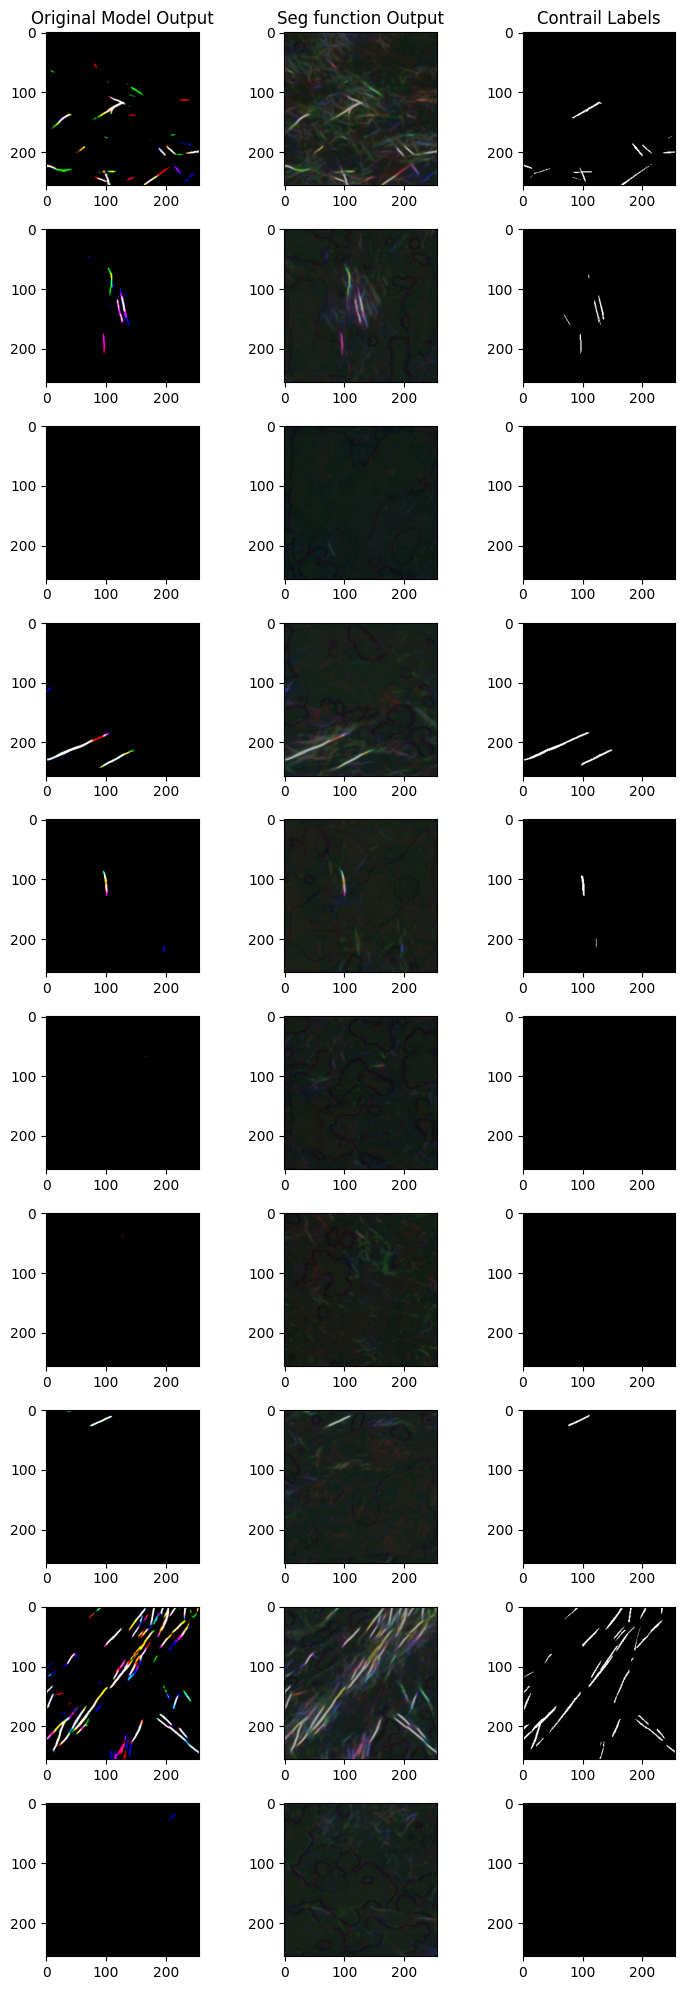

In [66]:
fig, axes = plt.subplots(len(y_list_from_seg), 3)
fig.set_size_inches((7.5,20))
for i in range(len(y_list_from_seg)):
    axes[i][0].imshow(y_list_from_origin[i][4])
    axes[i][1].imshow(y_list_from_seg[i][4])
    axes[i][2].imshow(labels[i], cmap='gray')
    if i == 0:
        axes[i][0].set_title('Original Model Output')
        axes[i][1].set_title('Seg function Output')
        axes[i][2].set_title('Contrail Labels')
fig.tight_layout()

由於前面 seg 系列函式當中有一個要求，<br>
就是原始 model 輸出等於 threshold 的時候，seg 輸出要等於 0.5，<br>
所以這裡要求紅點落在藍點們形成的曲線上，同時要求藍點要形成一條細曲線。

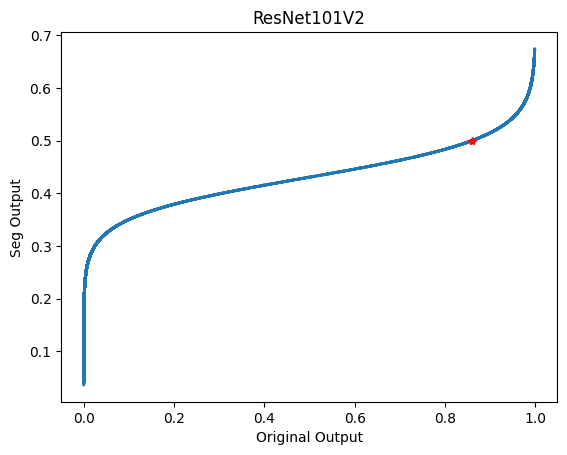

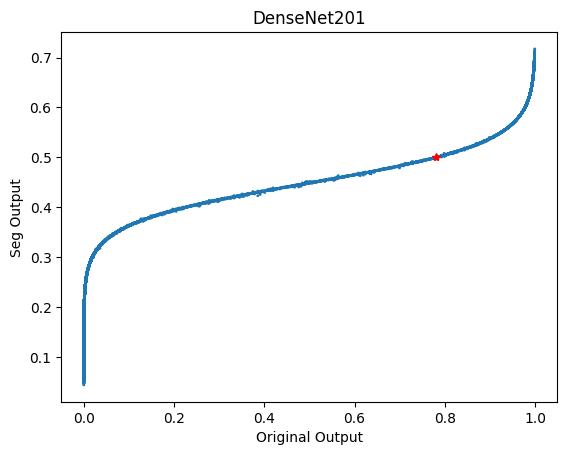

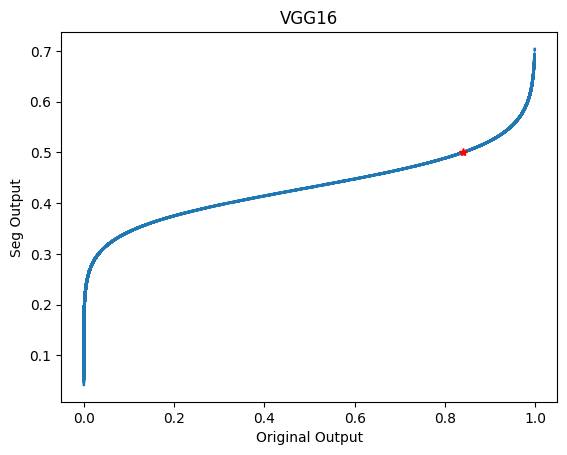

In [68]:
for i in range(3):
    y_seg = y_list_from_seg[0][:,:,:,i].flatten()
    y_org = y_list_from_origin[0][:,:,:,i].flatten()
    fig, ax = plt.subplots()
    ax.scatter(y_org, y_seg, y_org * 0 + 1)
    ax.plot([my_cuts[i]], [0.5], 'r*')
    ax.set_xlabel('Original Output')
    ax.set_ylabel('Seg Output')
    ax.set_title(backbone_list[i])

## Load And Compute

Fold 1: 1 samples.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.83s/it]


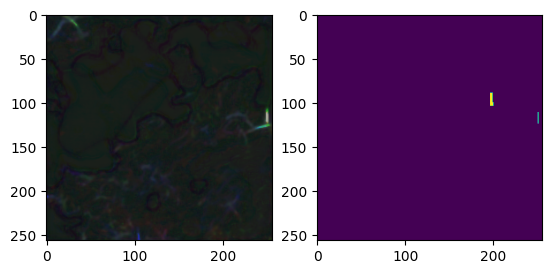

In [21]:
#=================================================
k = 4
renew = True
#===================================================================
#==================================================================

fold = 1
train_list = []
with open(f'fold_{fold:02d}.txt', 'r') as f:
    this_list = f.readlines()
    
j = np.random.randint(len(this_list))
for item in this_list[j:j+1]:
    this_fn = item.replace('\n', '/')
    this_split = this_fn.split('/')
    this_output_fn_X = this_split[1] + '_' + this_split[2] + '.npy'
    if not os.path.exists(output_path + this_output_fn_X) or renew:
        train_list.append(this_fn)
print(f'Fold {fold}: {len(train_list)} samples.')

time_steps_projection = np.zeros((8,8))
for i in range(8):
    time_steps_projection[i,i] = 1
DL = Data_Loader(time_steps_projection=time_steps_projection)
Xs, ys = DL.load_all_data(train_list, mode = 'valid')

for i in tqdm(range(len(train_list))):
        
    this_fn = train_list[i]
    this_split = this_fn.split('/')
    this_output_fn_X = this_split[1] + '_' + this_split[2] + '.npy'
    this_output_fn_y = this_split[1] + '_' + this_split[2] + '_GroundTruth.npy'

    #output_fn = train_list[i].split('/')[1] + '_' + train_list[i].split('/')[2] + '.npy'
    yp = seg_a_sample(Xs[i], my_models,
                      include_top=include_top, thresholds=my_cuts, k=k)

    np.save(output_path + this_output_fn_X, yp)
    np.save(output_path + this_output_fn_y, ys[i])

fig, ax = plt.subplots(1,2)
ax[0].imshow(yp[4])
ax[1].imshow(ys[-1])

### Loop Over Folds

In [28]:
for fold in fold_nums:
    train_list = []
    with open(f'fold_{fold:02d}.txt', 'r') as f:
        this_list = f.readlines()
    for item in this_list:
        this_fn = item.replace('\n', '/')
        this_split = this_fn.split('/')
        this_output_fn_X = this_split[1] + '_' + this_split[2] + '.npy'
        if not os.path.exists(output_path + this_output_fn_X) or renew:
            train_list.append(this_fn)
    print(f'Fold {fold}: {len(train_list)} samples.')
    
    time_steps_projection = np.zeros((8,8))
    for i in range(8):
        time_steps_projection[i,i] = 1
    DL = Data_Loader(time_steps_projection=time_steps_projection)
    Xs, ys = DL.load_all_data(train_list, mode = 'valid')
    
    for i in tqdm(range(len(train_list))):
        
        this_fn = train_list[i]
        this_split = this_fn.split('/')
        this_output_fn_X = this_split[1] + '_' + this_split[2] + '.npy'
        this_output_fn_y = this_split[1] + '_' + this_split[2] + '_GroundTruth.npy'
        
        #output_fn = train_list[i].split('/')[1] + '_' + train_list[i].split('/')[2] + '.npy'
        yp = seg_a_sample(Xs[i], my_models,
                      include_top=include_top, thresholds=my_cuts, k=k)
        
        np.save(output_path + this_output_fn_X, yp)
        np.save(output_path + this_output_fn_y, ys[i])

        #output_fn = train_list[i].split('/')[1] + '_' + train_list[i].split('/')[2] + '_GroundTruth.npy'
        

Fold 3: 2053 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [23:26<00:00,  1.46it/s]


Fold 4: 2053 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [23:48<00:00,  1.44it/s]


Fold 5: 2053 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [24:15<00:00,  1.41it/s]


Fold 6: 2053 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [24:24<00:00,  1.40it/s]


Fold 0: 2052 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2052/2052 [25:01<00:00,  1.37it/s]


Fold 1: 2053 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [27:47<00:00,  1.23it/s]


Fold 2: 2053 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [29:27<00:00,  1.16it/s]


Fold 7: 2053 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [26:48<00:00,  1.28it/s]


Fold 8: 2053 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [27:36<00:00,  1.24it/s]


Fold 9: 2053 samples.


100%|██████████████████████████████████████████████████████████████████████████████| 2053/2053 [30:29<00:00,  1.12it/s]
